In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Load processed data set
processed_df = pl.read_parquet("processed_data/comprehensive_eeg_features.parquet")

print(f"Shape: {processed_df.shape}")
print(f"Columns: {processed_df.columns}")

Shape: (245, 2893)
Columns: ['seizure_index', 'patient_id', 'seizure_bool', 'sampling_rate_hz', 'seizure_number', 'file_name', 'registration_start_time', 'registration_end_time', 'seizure_start_time', 'seizure_end_time', 'age', 'gender', 'num_channels', 'json_file_path', 'eeg_channel', 'seizure_type', 'localization', 'lateralization', 'file_path', 'sampling_rate', 'duration_seconds', 'seizure_start_seconds', 'seizure_end_seconds', 'seizure_de_infraslow_mean', 'seizure_de_infraslow_std', 'seizure_de_infraslow_median', 'seizure_de_infraslow_max', 'seizure_de_infraslow_min', 'seizure_de_infraslow_asymmetry_mean', 'seizure_de_infraslow_asymmetry_std', 'seizure_de_delta_mean', 'seizure_de_delta_std', 'seizure_de_delta_median', 'seizure_de_delta_max', 'seizure_de_delta_min', 'seizure_de_delta_asymmetry_mean', 'seizure_de_delta_asymmetry_std', 'seizure_de_theta_mean', 'seizure_de_theta_std', 'seizure_de_theta_median', 'seizure_de_theta_max', 'seizure_de_theta_min', 'seizure_de_theta_asymmetry

In [3]:
# Function to categorize age groups
def categorize_age_zc(df, age_threshold=22):
    return df.with_columns(
        pl.when(pl.col("age") < age_threshold)
        .then(pl.lit("Children"))
        .otherwise(pl.lit("Adults"))
        .alias("age_group")
    )

In [4]:
# Function to compare zero crossings std between groups
def compare_zero_crossings_std(df, age_threshold=22):
    # Categorize age groups
    df_categorized = categorize_age_zc(df, age_threshold)
    
    # Filter out null values
    df_clean = df_categorized.filter(
        pl.col("seizure_time_zero_crossings_std").is_not_null() & 
        pl.col("age").is_not_null()
    )
    
    # Group by age category and calculate statistics
    stats_by_group = df_clean.group_by("age_group").agg([
        pl.col("seizure_time_zero_crossings_std").mean().alias("mean_zc_std"),
        pl.col("seizure_time_zero_crossings_std").median().alias("median_zc_std"),
        pl.col("seizure_time_zero_crossings_std").std().alias("std_zc_std"),
        pl.col("seizure_time_zero_crossings_std").min().alias("min_zc_std"),
        pl.col("seizure_time_zero_crossings_std").max().alias("max_zc_std"),
        pl.col("seizure_time_zero_crossings_std").quantile(0.25).alias("q25_zc_std"),
        pl.col("seizure_time_zero_crossings_std").quantile(0.75).alias("q75_zc_std"),
        pl.col("seizure_time_zero_crossings_std").count().alias("count")
    ])
    
    print("Zero Crossings STD Statistics by Age Group:")
    print(stats_by_group)
    
    return df_clean, stats_by_group

In [5]:
# Function to plot zero crossings comparison
def plot_zero_crossings_comparison(df_clean):
    """Create visualization comparing zero crossings std between age groups"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Convert to pandas for plotting
    df_pandas = df_clean.to_pandas()
    
    # Box plot
    axes[0, 0].set_title('Zero Crossings STD Distribution by Age Group')
    sns.boxplot(data=df_pandas, x='age_group', y='seizure_time_zero_crossings_std', ax=axes[0, 0])
    axes[0, 0].set_ylabel('Time Zero Crossings STD')
    axes[0, 0].set_xlabel('Age Group')
    
    # Violin plot
    axes[0, 1].set_title('Zero Crossings STD Density by Age Group')
    sns.violinplot(data=df_pandas, x='age_group', y='seizure_time_zero_crossings_std', ax=axes[0, 1])
    axes[0, 1].set_ylabel('Time Zero Crossings STD')
    axes[0, 1].set_xlabel('Age Group')
    
    # Scatter plot with age as continuous
    axes[0, 2].set_title('Zero Crossings STD vs Age (Continuous)')
    scatter = axes[0, 2].scatter(df_pandas['age'], df_pandas['seizure_time_zero_crossings_std'], 
                                 alpha=0.5, c=df_pandas['age'], cmap='viridis')
    axes[0, 2].set_xlabel('Age (years)')
    axes[0, 2].set_ylabel('Time Zero Crossings STD')
    axes[0, 2].axvline(x=22, color='r', linestyle='--', alpha=0.5, label='Adult threshold')
    axes[0, 2].legend()
    plt.colorbar(scatter, ax=axes[0, 2])
    
    # Histogram comparison
    axes[1, 0].set_title('Distribution of Zero Crossings STD')
    children_data = df_pandas[df_pandas['age_group'] == 'Children']['seizure_time_zero_crossings_std']
    adult_data = df_pandas[df_pandas['age_group'] == 'Adults']['seizure_time_zero_crossings_std']
    axes[1, 0].hist(children_data, alpha=0.5, label='Children', bins=30, density=True)
    axes[1, 0].hist(adult_data, alpha=0.5, label='Adults', bins=30, density=True)
    axes[1, 0].set_xlabel('Time Zero Crossings STD')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    
    # Q-Q plot for normality check
    axes[1, 1].set_title('Q-Q Plot: Children vs Normal Distribution')
    stats.probplot(children_data.dropna(), dist="norm", plot=axes[1, 1])
    
    # Cumulative distribution
    axes[1, 2].set_title('Cumulative Distribution Function')
    children_sorted = np.sort(children_data.dropna())
    adult_sorted = np.sort(adult_data.dropna())
    axes[1, 2].plot(children_sorted, np.arange(1, len(children_sorted)+1)/len(children_sorted), 
                   label='Children', linewidth=2)
    axes[1, 2].plot(adult_sorted, np.arange(1, len(adult_sorted)+1)/len(adult_sorted), 
                   label='Adults', linewidth=2)
    axes[1, 2].set_xlabel('Time Zero Crossings STD')
    axes[1, 2].set_ylabel('Cumulative Probability')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plot_outputs/zero_crossings_std_comparison.png')
    plt.show()

In [6]:
# Statistical testing function
def statistical_comparison_zc(df_clean):
    """Perform comprehensive statistical tests comparing children vs adults"""
    df_pandas = df_clean.to_pandas()
    
    children_zc = df_pandas[df_pandas['age_group'] == 'Children']['seizure_time_zero_crossings_std'].dropna()
    adult_zc = df_pandas[df_pandas['age_group'] == 'Adults']['seizure_time_zero_crossings_std'].dropna()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(children_zc, adult_zc)
    
    # Mann-Whitney U test (non-parametric)
    u_stat, p_value_mw = stats.mannwhitneyu(children_zc, adult_zc)
    
    # Kolmogorov-Smirnov test
    ks_stat, p_value_ks = stats.ks_2samp(children_zc, adult_zc)
    
    # Effect size (Cohen's d)
    cohens_d = (children_zc.mean() - adult_zc.mean()) / np.sqrt(((children_zc.std()**2 + adult_zc.std()**2) / 2))
    
    print("\nStatistical Tests for Zero Crossings STD:")
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {p_value_mw:.4f}")
    print(f"Kolmogorov-Smirnov test: KS-statistic = {ks_stat:.4f}, p-value = {p_value_ks:.4f}")
    print(f"Cohen's d (effect size): {cohens_d:.4f}")
    
    # Interpretation
    if abs(cohens_d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    print(f"Effect size interpretation: {effect_interpretation}")
    
    return t_stat, p_value, u_stat, p_value_mw, cohens_d

In [7]:
processed_df_clean, stats_by_group = compare_zero_crossings_std(processed_df)

Zero Crossings STD Statistics by Age Group:
shape: (2, 9)
┌───────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────┐
│ age_group ┆ mean_zc_st ┆ median_zc_ ┆ std_zc_std ┆ … ┆ max_zc_st ┆ q25_zc_st ┆ q75_zc_st ┆ count │
│ ---       ┆ d          ┆ std        ┆ ---        ┆   ┆ d         ┆ d         ┆ d         ┆ ---   │
│ str       ┆ ---        ┆ ---        ┆ f64        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ u32   │
│           ┆ f64        ┆ f64        ┆            ┆   ┆ f64       ┆ f64       ┆ f64       ┆       │
╞═══════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ Adults    ┆ 22.111927  ┆ 19.441523  ┆ 10.591153  ┆ … ┆ 42.658169 ┆ 13.338396 ┆ 30.811356 ┆ 50    │
│ Children  ┆ 9.355988   ┆ 8.777125   ┆ 4.870839   ┆ … ┆ 29.404993 ┆ 6.418877  ┆ 11.611203 ┆ 195   │
└───────────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴───────┘


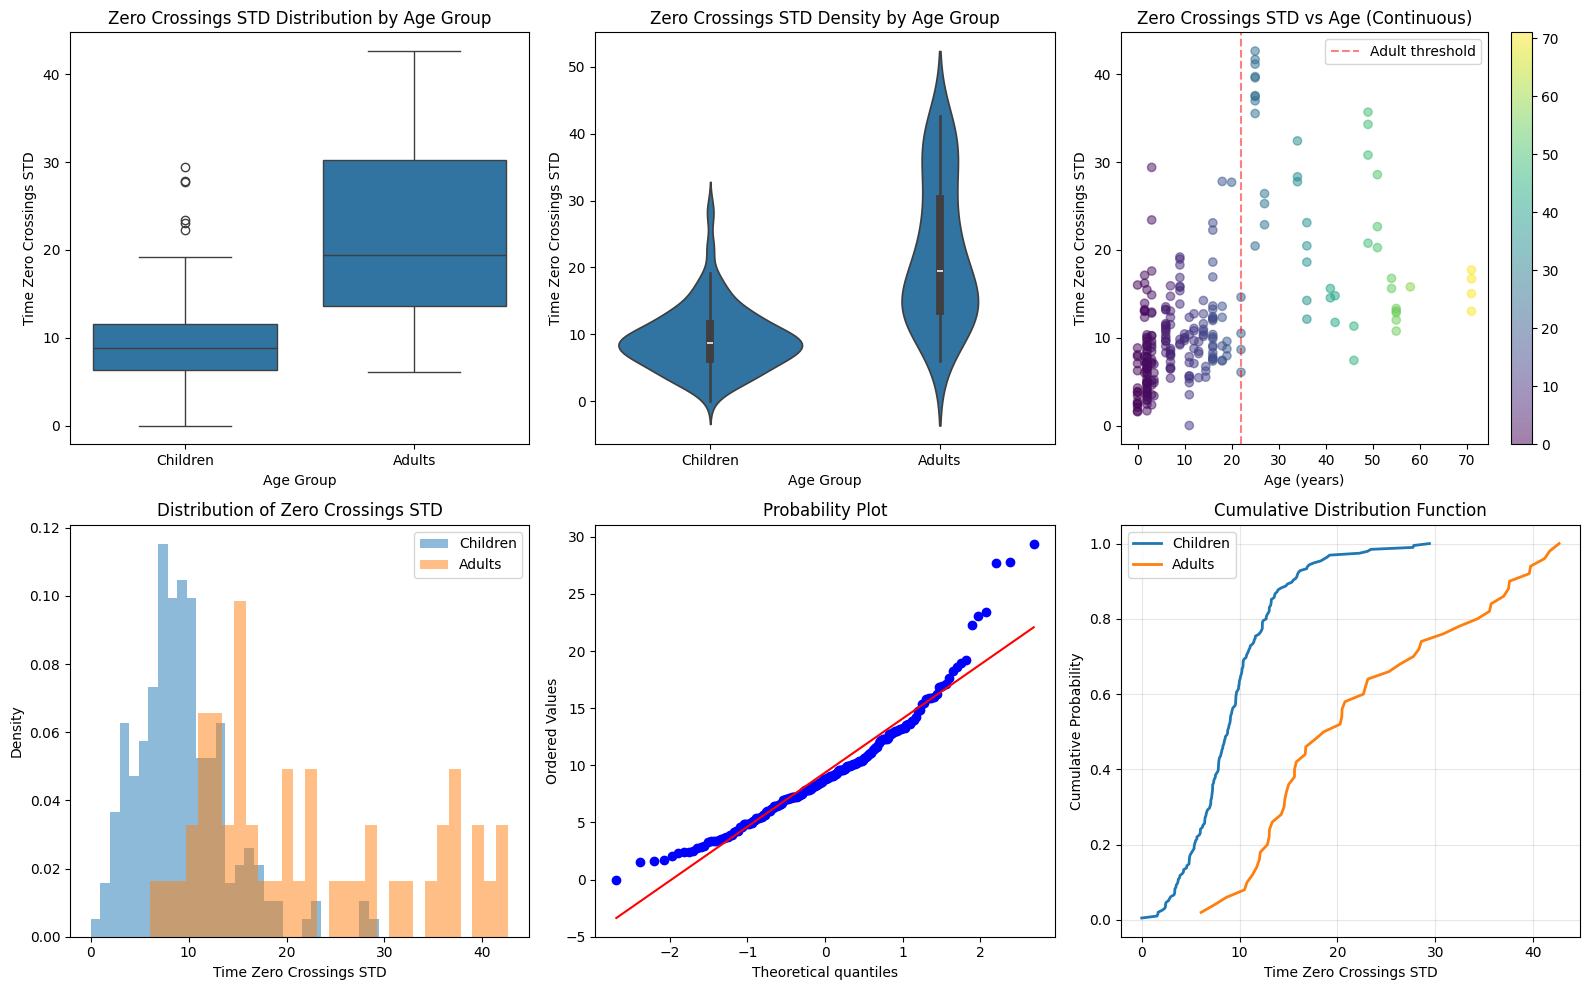

In [8]:
plot_zero_crossings_comparison(processed_df_clean)

In [9]:
statistical_comparison_zc(processed_df_clean)


Statistical Tests for Zero Crossings STD:
T-test: t-statistic = -12.4823, p-value = 0.0000
Mann-Whitney U test: U-statistic = 1083.0000, p-value = 0.0000
Kolmogorov-Smirnov test: KS-statistic = 0.6338, p-value = 0.0000
Cohen's d (effect size): -1.5475
Effect size interpretation: large


(np.float64(-12.48225756922269),
 np.float64(5.869130901074958e-28),
 np.float64(1083.0),
 np.float64(2.238385376068125e-17),
 np.float64(-1.547467588566931))

In [10]:
# Zero crossings relationship with other time-domain features
def analyze_zc_time_domain_relationships():
    """Analyze relationships between zero crossings and other time-domain features"""
    time_features = ['seizure_time_zero_crossings_std', 'seizure_time_zero_crossings_mean', 
                    'seizure_time_hjorth_mobility_mean', 'seizure_time_hjorth_complexity_mean',
                    'seizure_time_line_length_mean', 'seizure_time_rms_mean', 
                    'seizure_time_peak_to_peak_mean', 'seizure_time_var_mean']
    
    df_time = processed_df_clean.select(time_features + ['age']).to_pandas()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Correlation heatmap
    corr_matrix = df_time[time_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[0, 0], cbar_kws={"shrink": 0.8})
    axes[0, 0].set_title('Time-Domain Feature Correlations')
    
    # Zero crossings mean vs std
    axes[0, 1].set_title('Zero Crossings: Mean vs STD')
    scatter = axes[0, 1].scatter(df_time['seizure_time_zero_crossings_mean'], 
                                 df_time['seizure_time_zero_crossings_std'],
                                 c=df_time['age'], cmap='viridis', alpha=0.5)
    axes[0, 1].set_xlabel('Zero Crossings Mean')
    axes[0, 1].set_ylabel('Zero Crossings STD')
    plt.colorbar(scatter, ax=axes[0, 1], label='Age')
    
    # Zero crossings std vs Hjorth mobility
    axes[0, 2].set_title('Zero Crossings STD vs Hjorth Mobility')
    axes[0, 2].scatter(df_time['seizure_time_hjorth_mobility_mean'], 
                      df_time['seizure_time_zero_crossings_std'], alpha=0.5)
    axes[0, 2].set_xlabel('Hjorth Mobility Mean')
    axes[0, 2].set_ylabel('Zero Crossings STD')
    
    # Zero crossings std vs line length
    axes[1, 0].set_title('Zero Crossings STD vs Line Length')
    axes[1, 0].scatter(df_time['seizure_time_line_length_mean'], 
                      df_time['seizure_time_zero_crossings_std'], alpha=0.5)
    axes[1, 0].set_xlabel('Line Length Mean')
    axes[1, 0].set_ylabel('Zero Crossings STD')
    
    # Zero crossings std vs RMS
    axes[1, 1].set_title('Zero Crossings STD vs RMS')
    axes[1, 1].scatter(df_time['seizure_time_rms_mean'], 
                      df_time['seizure_time_zero_crossings_std'], alpha=0.5)
    axes[1, 1].set_xlabel('RMS Mean')
    axes[1, 1].set_ylabel('Zero Crossings STD')
    
    # Zero crossings std vs variance
    axes[1, 2].set_title('Zero Crossings STD vs Signal Variance')
    hexbin = axes[1, 2].hexbin(df_time['seizure_time_var_mean'], 
                               df_time['seizure_time_zero_crossings_std'],
                               gridsize=20, cmap='YlOrRd')
    axes[1, 2].set_xlabel('Signal Variance Mean')
    axes[1, 2].set_ylabel('Zero Crossings STD')
    plt.colorbar(hexbin, ax=axes[1, 2])
    
    plt.tight_layout()
    plt.savefig('plot_outputs/time_domain_relationships.png')
    plt.show()

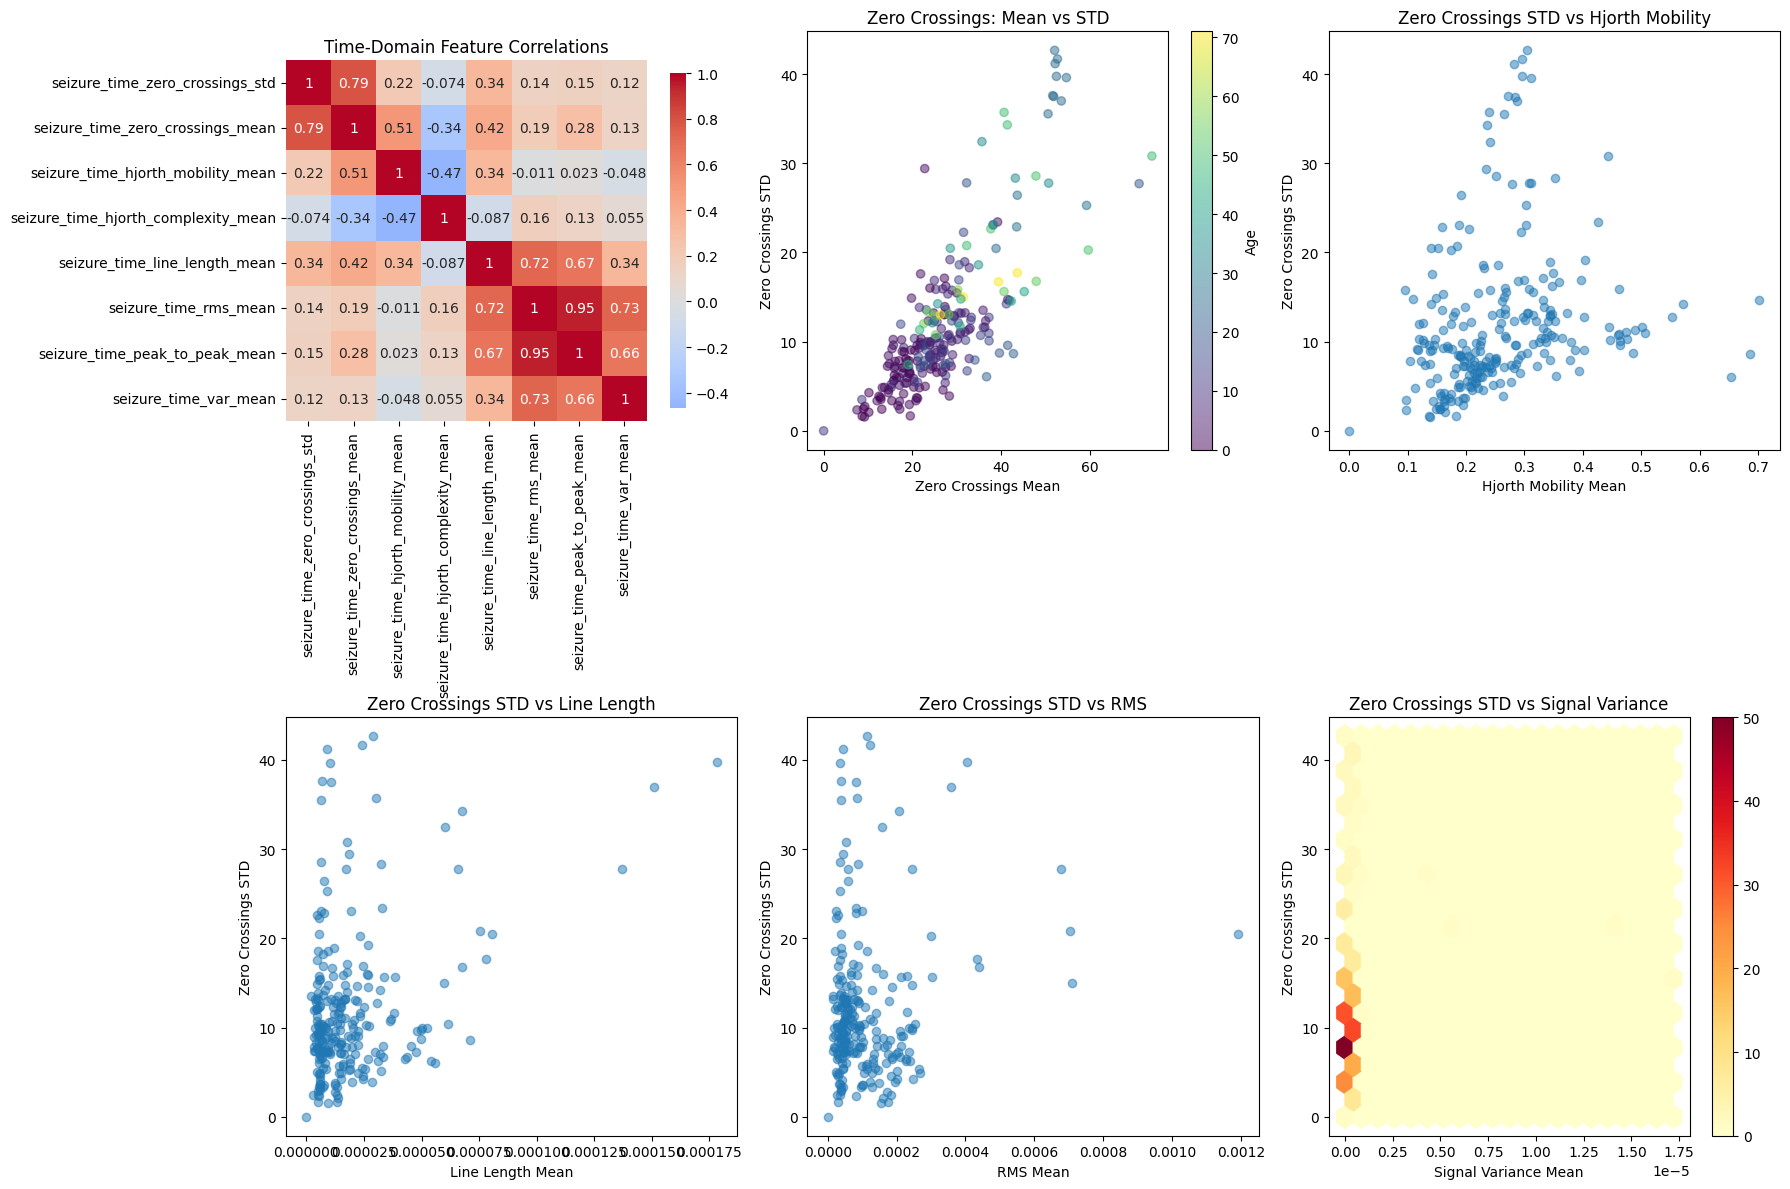

In [11]:
analyze_zc_time_domain_relationships()

In [12]:
# Function to compare propagation speed features between age groups
def compare_propagation_speed(df, feature_name, age_threshold=22):
    # Categorize age groups
    df_categorized = categorize_age_zc(df, age_threshold)
    
    # Filter out null values
    df_clean = df_categorized.filter(
        pl.col(feature_name).is_not_null() & 
        pl.col("age").is_not_null()
    )
    
    # Group by age category and calculate statistics
    stats_by_group = df_clean.group_by("age_group").agg([
        pl.col(feature_name).mean().alias(f"mean_{feature_name}"),
        pl.col(feature_name).median().alias(f"median_{feature_name}"),
        pl.col(feature_name).std().alias(f"std_{feature_name}"),
        pl.col(feature_name).min().alias(f"min_{feature_name}"),
        pl.col(feature_name).max().alias(f"max_{feature_name}"),
        pl.col(feature_name).quantile(0.25).alias(f"q25_{feature_name}"),
        pl.col(feature_name).quantile(0.75).alias(f"q75_{feature_name}"),
        pl.col(feature_name).count().alias("count")
    ])
    
    print(f"\n{feature_name} Statistics by Age Group:")
    print(stats_by_group)
    
    return df_clean, stats_by_group

In [13]:
# Function to plot propagation speed comparison
def plot_propagation_speed_comparison(df_clean, feature_name, age_threshold=22):
    """Create visualization comparing propagation speed feature between age groups"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Convert to pandas for plotting
    df_pandas = df_clean.to_pandas()
    
    # Box plot
    axes[0, 0].set_title(f'{feature_name} Distribution by Age Group')
    sns.boxplot(data=df_pandas, x='age_group', y=feature_name, ax=axes[0, 0])
    axes[0, 0].set_ylabel(feature_name)
    axes[0, 0].set_xlabel('Age Group')
    
    # Violin plot
    axes[0, 1].set_title(f'{feature_name} Density by Age Group')
    sns.violinplot(data=df_pandas, x='age_group', y=feature_name, ax=axes[0, 1])
    axes[0, 1].set_ylabel(feature_name)
    axes[0, 1].set_xlabel('Age Group')
    
    # Scatter plot with age as continuous
    axes[0, 2].set_title(f'{feature_name} vs Age (Continuous)')
    scatter = axes[0, 2].scatter(df_pandas['age'], df_pandas[feature_name], 
                                 alpha=0.5, c=df_pandas['age'], cmap='viridis')
    axes[0, 2].set_xlabel('Age (years)')
    axes[0, 2].set_ylabel(feature_name)
    axes[0, 2].axvline(x=age_threshold, color='r', linestyle='--', alpha=0.5, label=f'Adult threshold ({age_threshold})')
    axes[0, 2].legend()
    plt.colorbar(scatter, ax=axes[0, 2])
    
    # Histogram comparison
    axes[1, 0].set_title(f'Distribution of {feature_name}')
    children_data = df_pandas[df_pandas['age_group'] == 'Children'][feature_name]
    adult_data = df_pandas[df_pandas['age_group'] == 'Adults'][feature_name]
    axes[1, 0].hist(children_data, alpha=0.5, label='Children', bins=30, density=True)
    axes[1, 0].hist(adult_data, alpha=0.5, label='Adults', bins=30, density=True)
    axes[1, 0].set_xlabel(feature_name)
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    
    # Q-Q plot for normality check
    axes[1, 1].set_title('Q-Q Plot: Children vs Normal Distribution')
    stats.probplot(children_data.dropna(), dist="norm", plot=axes[1, 1])
    
    # Cumulative distribution
    axes[1, 2].set_title('Cumulative Distribution Function')
    children_sorted = np.sort(children_data.dropna())
    adult_sorted = np.sort(adult_data.dropna())
    axes[1, 2].plot(children_sorted, np.arange(1, len(children_sorted)+1)/len(children_sorted), 
                   label='Children', linewidth=2)
    axes[1, 2].plot(adult_sorted, np.arange(1, len(adult_sorted)+1)/len(adult_sorted), 
                   label='Adults', linewidth=2)
    axes[1, 2].set_xlabel(feature_name)
    axes[1, 2].set_ylabel('Cumulative Probability')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'plot_outputs/{feature_name}_comparison.png')
    plt.show()

In [14]:
# Statistical testing function for propagation speed
def statistical_comparison_prop_speed(df_clean, feature_name):
    """Perform comprehensive statistical tests comparing children vs adults for propagation speed"""
    df_pandas = df_clean.to_pandas()
    
    children_data = df_pandas[df_pandas['age_group'] == 'Children'][feature_name].dropna()
    adult_data = df_pandas[df_pandas['age_group'] == 'Adults'][feature_name].dropna()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(children_data, adult_data)
    
    # Mann-Whitney U test (non-parametric)
    u_stat, p_value_mw = stats.mannwhitneyu(children_data, adult_data)
    
    # Kolmogorov-Smirnov test
    ks_stat, p_value_ks = stats.ks_2samp(children_data, adult_data)
    
    # Effect size (Cohen's d)
    cohens_d = (children_data.mean() - adult_data.mean()) / np.sqrt(((children_data.std()**2 + adult_data.std()**2) / 2))
    
    print(f"\nStatistical Tests for {feature_name}:")
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {p_value_mw:.4f}")
    print(f"Kolmogorov-Smirnov test: KS-statistic = {ks_stat:.4f}, p-value = {p_value_ks:.4f}")
    print(f"Cohen's d (effect size): {cohens_d:.4f}")
    
    # Interpretation
    if abs(cohens_d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    print(f"Effect size interpretation: {effect_interpretation}")
    
    return {
        'feature': feature_name,
        't_stat': t_stat,
        'p_value': p_value,
        'u_stat': u_stat,
        'p_value_mw': p_value_mw,
        'ks_stat': ks_stat,
        'p_value_ks': p_value_ks,
        'cohens_d': cohens_d,
        'effect_interpretation': effect_interpretation
    }

In [15]:
# Function to analyze all propagation speed features
def analyze_all_propagation_speeds(df, age_threshold=22):
    """Run complete analysis for all three propagation speed features"""
    
    prop_speed_features = [
        'seizure_mean_propagation_speed',
        'seizure_std_propagation_speed', 
        'seizure_max_propagation_speed'
    ]
    
    all_results = []
    
    for feature in prop_speed_features:
        print(f"\n{'='*60}")
        print(f"Analyzing: {feature}")
        print('='*60)
        
        # Compare statistics
        df_clean, stats_by_group = compare_propagation_speed(df, feature, age_threshold)
        
        # Plot comparisons
        plot_propagation_speed_comparison(df_clean, feature, age_threshold)
        
        # Statistical tests
        stats_results = statistical_comparison_prop_speed(df_clean, feature)
        all_results.append(stats_results)
    
    return all_results

In [16]:
# Function to compare all three propagation speeds in one plot
def plot_all_propagation_speeds_comparison(df, age_threshold=22):
    """Create a combined visualization for all propagation speed features"""
    
    prop_speed_features = [
        'seizure_mean_propagation_speed',
        'seizure_std_propagation_speed', 
        'seizure_max_propagation_speed'
    ]
    
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    
    for idx, feature in enumerate(prop_speed_features):
        # Prepare data
        df_categorized = categorize_age_zc(df, age_threshold)
        df_clean = df_categorized.filter(
            pl.col(feature).is_not_null() & 
            pl.col("age").is_not_null()
        )
        df_pandas = df_clean.to_pandas()
        
        # Box plot
        axes[idx, 0].set_title(f'{feature.replace("seizure_", "").replace("_", " ").title()}')
        sns.boxplot(data=df_pandas, x='age_group', y=feature, ax=axes[idx, 0])
        axes[idx, 0].set_ylabel(feature.replace("seizure_", "").replace("_", " "))
        axes[idx, 0].set_xlabel('Age Group')
        
        # Violin plot
        axes[idx, 1].set_title(f'Density Distribution')
        sns.violinplot(data=df_pandas, x='age_group', y=feature, ax=axes[idx, 1])
        axes[idx, 1].set_ylabel('')
        axes[idx, 1].set_xlabel('Age Group')
        
        # Scatter vs age
        scatter = axes[idx, 2].scatter(df_pandas['age'], df_pandas[feature], 
                                       alpha=0.5, c=df_pandas['age'], cmap='viridis')
        axes[idx, 2].set_xlabel('Age (years)')
        axes[idx, 2].set_ylabel('')
        axes[idx, 2].axvline(x=age_threshold, color='r', linestyle='--', alpha=0.5)
        axes[idx, 2].set_title('vs Age (continuous)')
        if idx == 0:
            plt.colorbar(scatter, ax=axes[idx, 2])
    
    plt.suptitle('Propagation Speed Features Comparison by Age Group', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('plot_outputs/all_propagation_speeds_comparison.png')
    plt.show()

In [17]:
# Function to analyze correlations between propagation speeds
def analyze_propagation_speed_correlations(df, age_threshold=22):
    """Analyze correlations between propagation speed features and age"""
    
    prop_speed_features = [
        'seizure_mean_propagation_speed',
        'seizure_std_propagation_speed', 
        'seizure_max_propagation_speed'
    ]
    
    # Prepare data
    df_categorized = categorize_age_zc(df, age_threshold)
    df_analysis = df_categorized.select(prop_speed_features + ['age', 'age_group']).to_pandas()
    
    # Calculate correlations
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Correlation heatmap
    corr_matrix = df_analysis[prop_speed_features + ['age']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
    axes[0].set_title('Propagation Speed Features Correlation Matrix')
    
    # Pairplot style scatter matrix
    axes[1].set_title('Mean vs Std Propagation Speed by Age Group')
    for age_group in ['Children', 'Adults']:
        data = df_analysis[df_analysis['age_group'] == age_group]
        axes[1].scatter(data['seizure_mean_propagation_speed'], 
                       data['seizure_std_propagation_speed'],
                       alpha=0.5, label=age_group)
    axes[1].set_xlabel('Mean Propagation Speed')
    axes[1].set_ylabel('Std Propagation Speed')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('plot_outputs/propagation_speed_correlations.png')
    plt.show()
    
    # Print correlation with age
    print("\nCorrelation with Age:")
    for feature in prop_speed_features:
        corr_with_age = df_analysis[[feature, 'age']].corr().iloc[0, 1]
        print(f"{feature}: {corr_with_age:.4f}")



Analyzing: seizure_mean_propagation_speed

seizure_mean_propagation_speed Statistics by Age Group:
shape: (2, 9)
┌───────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────┐
│ age_group ┆ mean_seizu ┆ median_sei ┆ std_seizur ┆ … ┆ max_seizu ┆ q25_seizu ┆ q75_seizu ┆ count │
│ ---       ┆ re_mean_pr ┆ zure_mean_ ┆ e_mean_pro ┆   ┆ re_mean_p ┆ re_mean_p ┆ re_mean_p ┆ ---   │
│ str       ┆ opagation_ ┆ propagatio ┆ pagation_s ┆   ┆ ropagatio ┆ ropagatio ┆ ropagatio ┆ u32   │
│           ┆ …          ┆ …          ┆ …          ┆   ┆ n_s…      ┆ n_s…      ┆ n_s…      ┆       │
│           ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆       │
│           ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64       ┆ f64       ┆ f64       ┆       │
╞═══════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ Adults    ┆ 1390.06736 ┆ 1412.87976 ┆ 526.467117 ┆ … ┆ 2411.2020 ┆ 937.14240

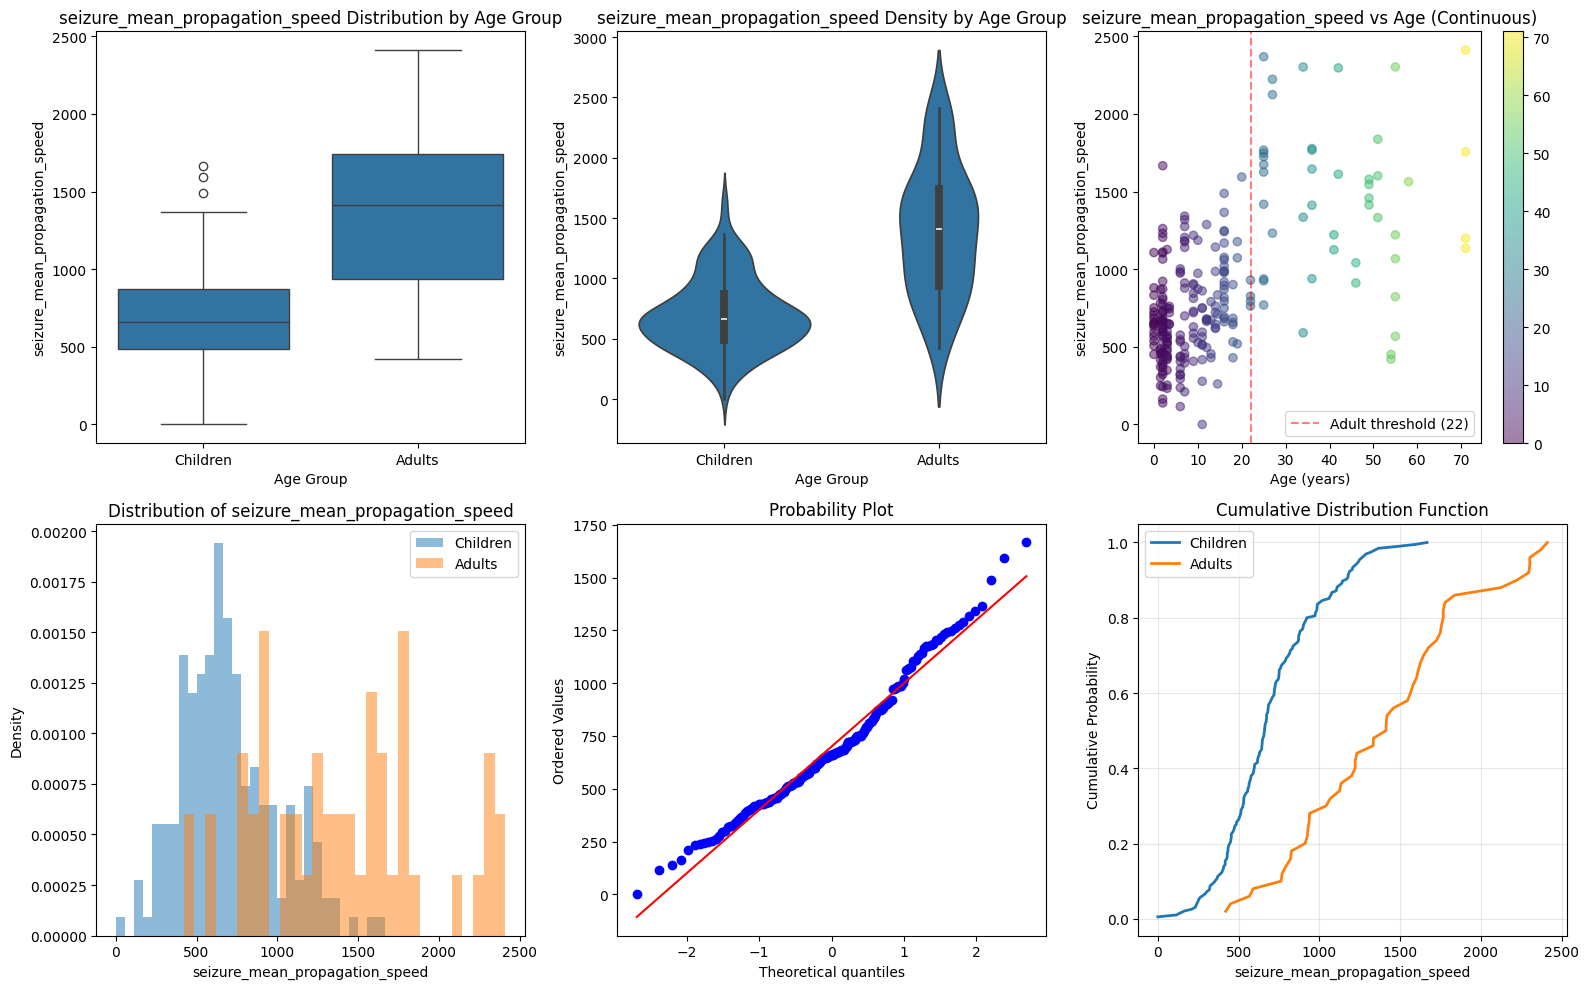


Statistical Tests for seizure_mean_propagation_speed:
T-test: t-statistic = -12.1588, p-value = 0.0000
Mann-Whitney U test: U-statistic = 1249.0000, p-value = 0.0000
Kolmogorov-Smirnov test: KS-statistic = 0.6046, p-value = 0.0000
Cohen's d (effect size): -1.6094
Effect size interpretation: large

Analyzing: seizure_std_propagation_speed

seizure_std_propagation_speed Statistics by Age Group:
shape: (2, 9)
┌───────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────┐
│ age_group ┆ mean_seizu ┆ median_sei ┆ std_seizur ┆ … ┆ max_seizu ┆ q25_seizu ┆ q75_seizu ┆ count │
│ ---       ┆ re_std_pro ┆ zure_std_p ┆ e_std_prop ┆   ┆ re_std_pr ┆ re_std_pr ┆ re_std_pr ┆ ---   │
│ str       ┆ pagation_s ┆ ropagation ┆ agation_sp ┆   ┆ opagation ┆ opagation ┆ opagation ┆ u32   │
│           ┆ …          ┆ …          ┆ …          ┆   ┆ _sp…      ┆ _sp…      ┆ _sp…      ┆       │
│           ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---

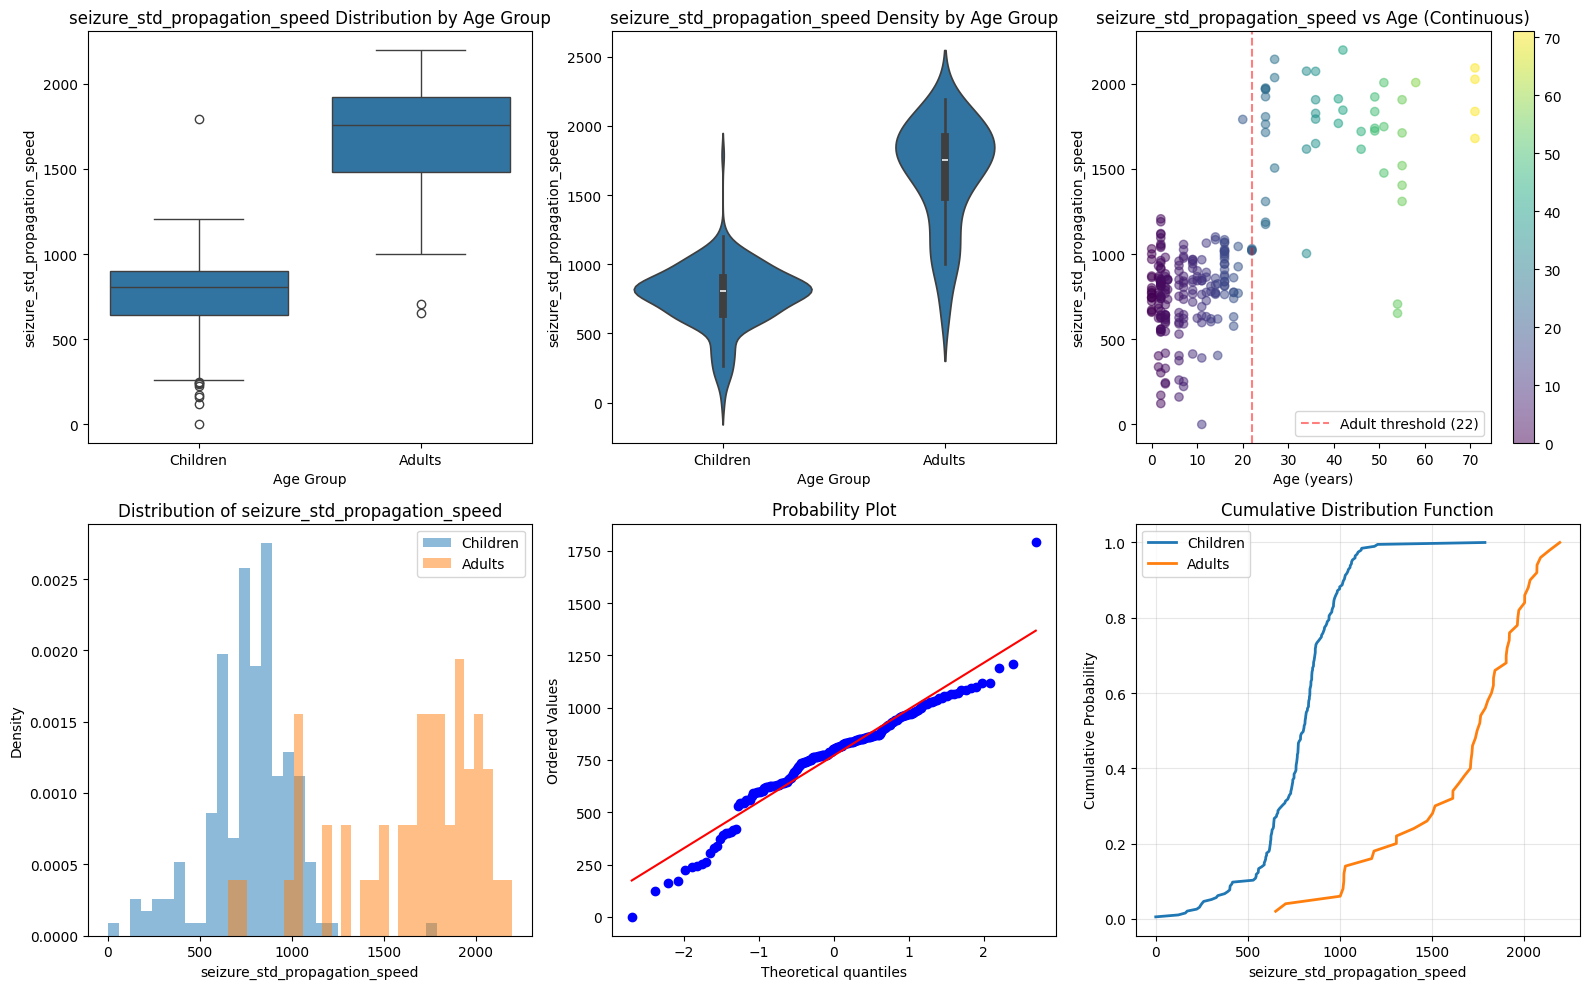


Statistical Tests for seizure_std_propagation_speed:
T-test: t-statistic = -20.9901, p-value = 0.0000
Mann-Whitney U test: U-statistic = 402.0000, p-value = 0.0000
Kolmogorov-Smirnov test: KS-statistic = 0.8446, p-value = 0.0000
Cohen's d (effect size): -2.8094
Effect size interpretation: large

Analyzing: seizure_max_propagation_speed

seizure_max_propagation_speed Statistics by Age Group:
shape: (2, 9)
┌───────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────┐
│ age_group ┆ mean_seizu ┆ median_sei ┆ std_seizur ┆ … ┆ max_seizu ┆ q25_seizu ┆ q75_seizu ┆ count │
│ ---       ┆ re_max_pro ┆ zure_max_p ┆ e_max_prop ┆   ┆ re_max_pr ┆ re_max_pr ┆ re_max_pr ┆ ---   │
│ str       ┆ pagation_s ┆ ropagation ┆ agation_sp ┆   ┆ opagation ┆ opagation ┆ opagation ┆ u32   │
│           ┆ …          ┆ …          ┆ …          ┆   ┆ _sp…      ┆ _sp…      ┆ _sp…      ┆       │
│           ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---  

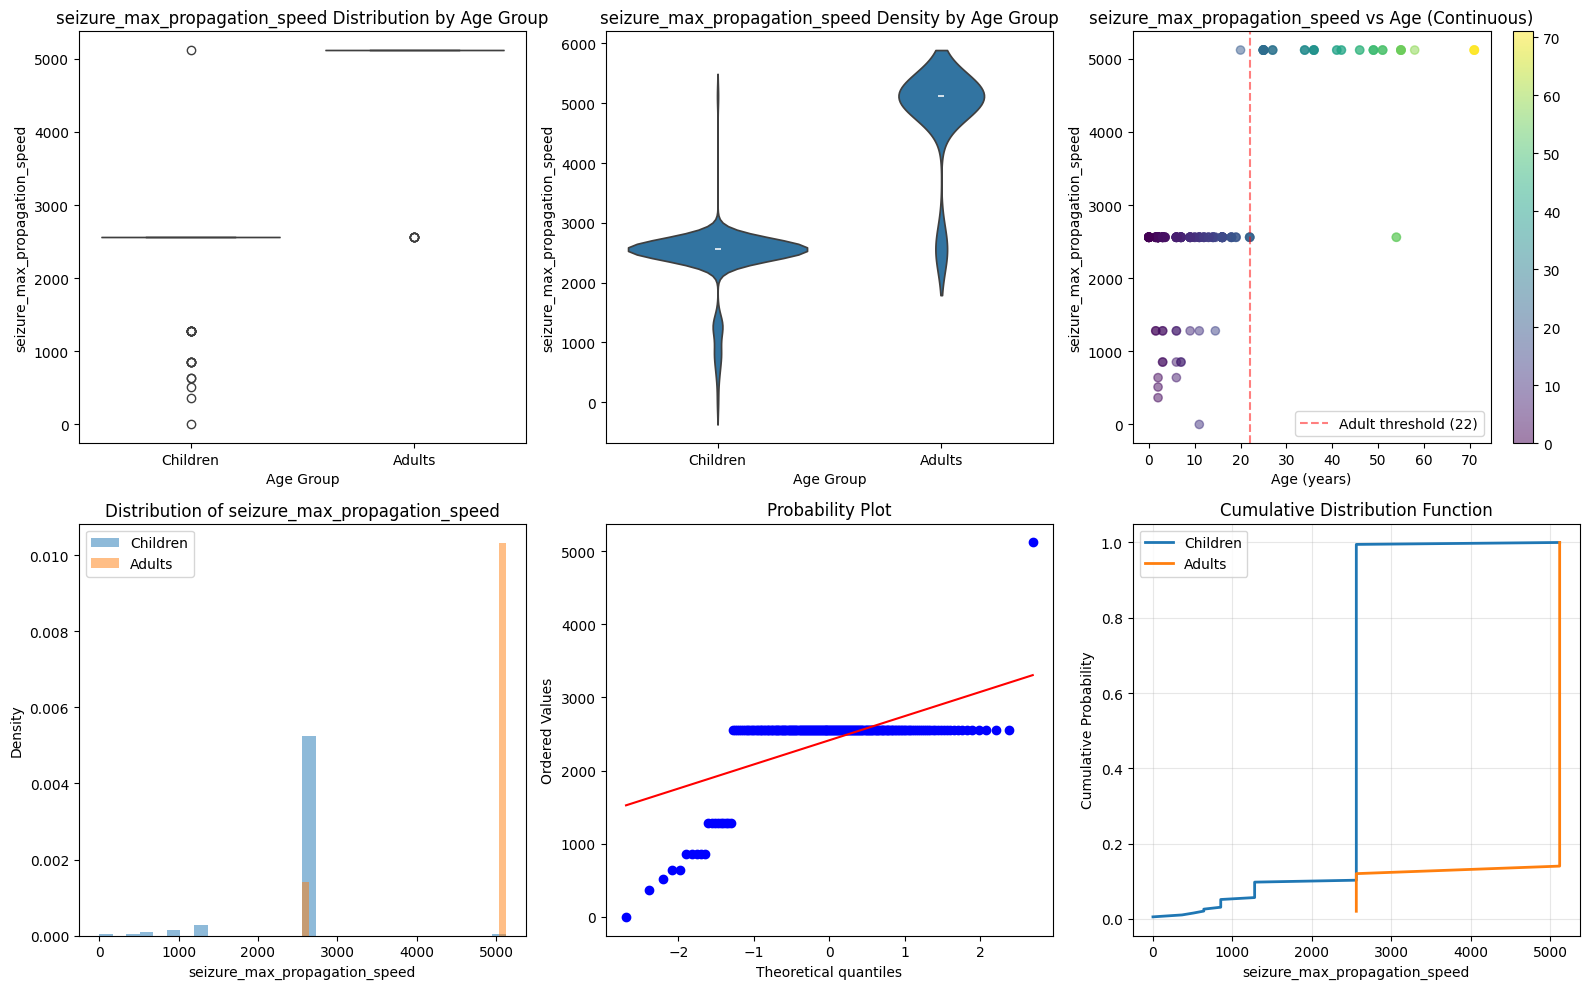


Statistical Tests for seizure_max_propagation_speed:
T-test: t-statistic = -24.9390, p-value = 0.0000
Mann-Whitney U test: U-statistic = 553.0000, p-value = 0.0000
Kolmogorov-Smirnov test: KS-statistic = 0.8749, p-value = 0.0000
Cohen's d (effect size): -3.4099
Effect size interpretation: large


In [18]:
results = analyze_all_propagation_speeds(processed_df, age_threshold=22)

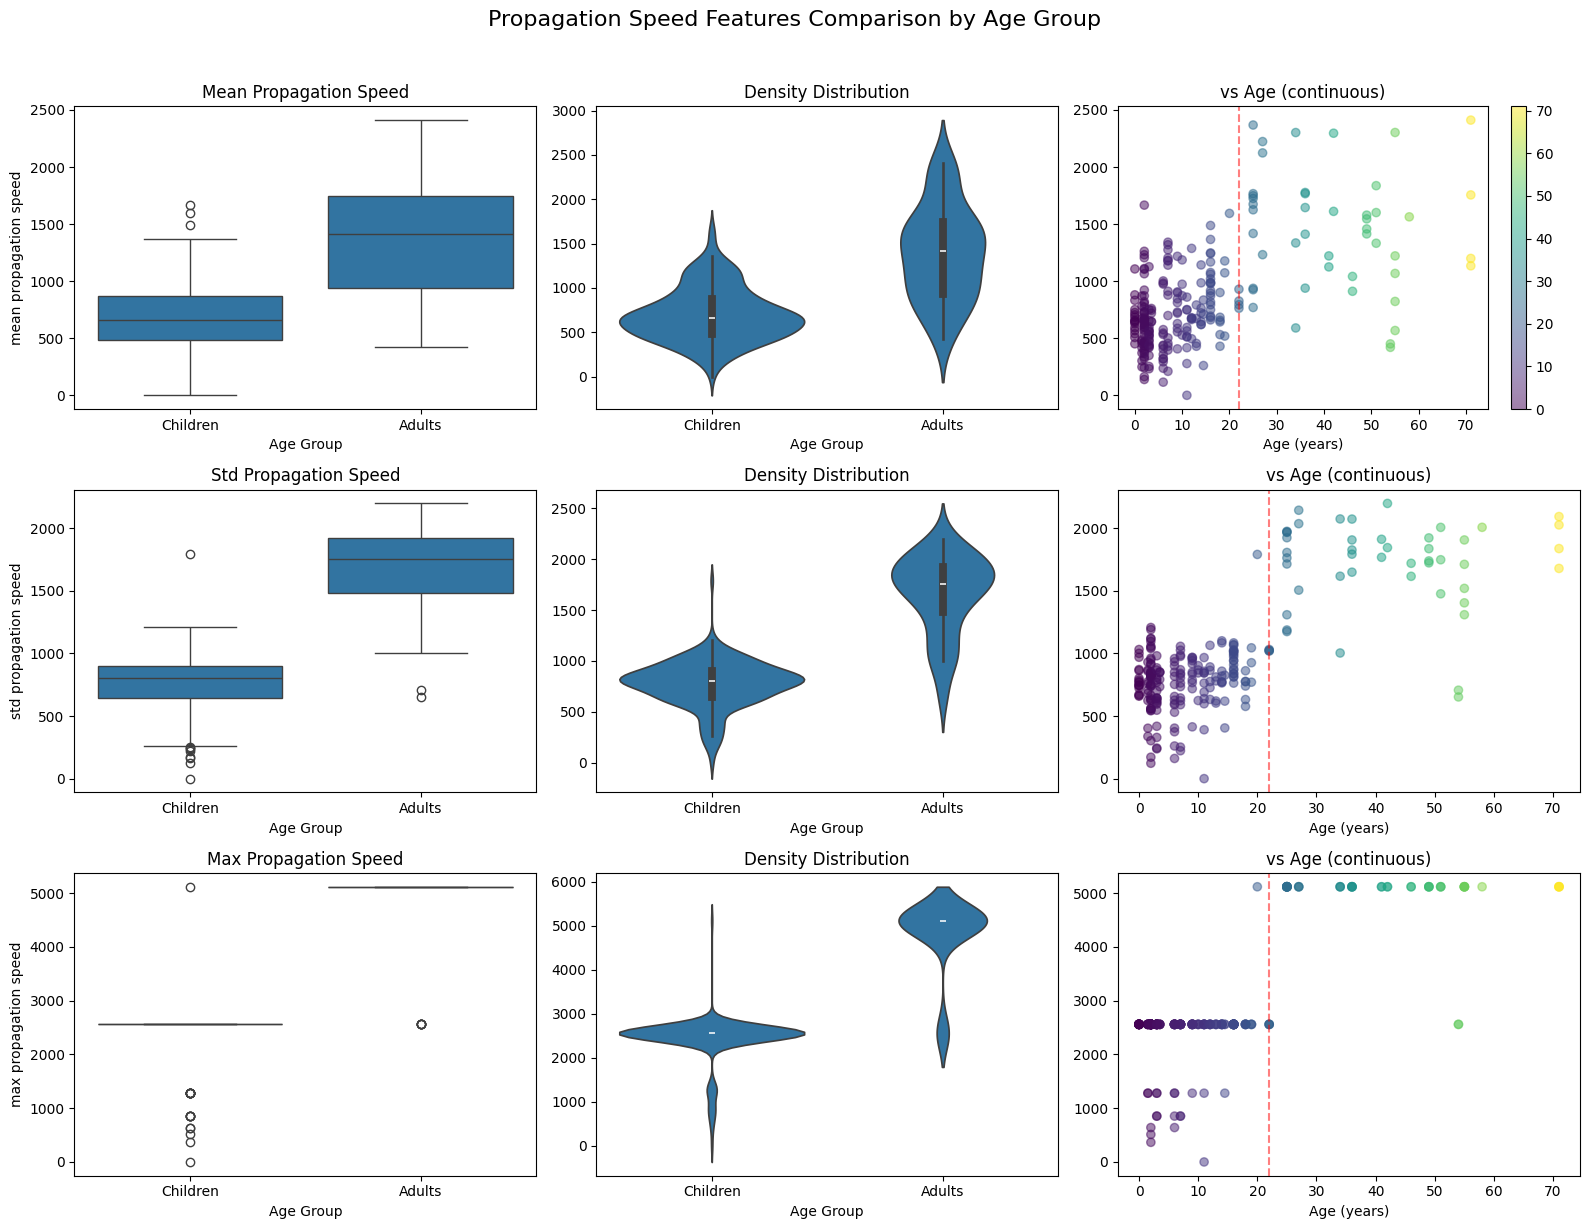

In [19]:
plot_all_propagation_speeds_comparison(processed_df, age_threshold=22)

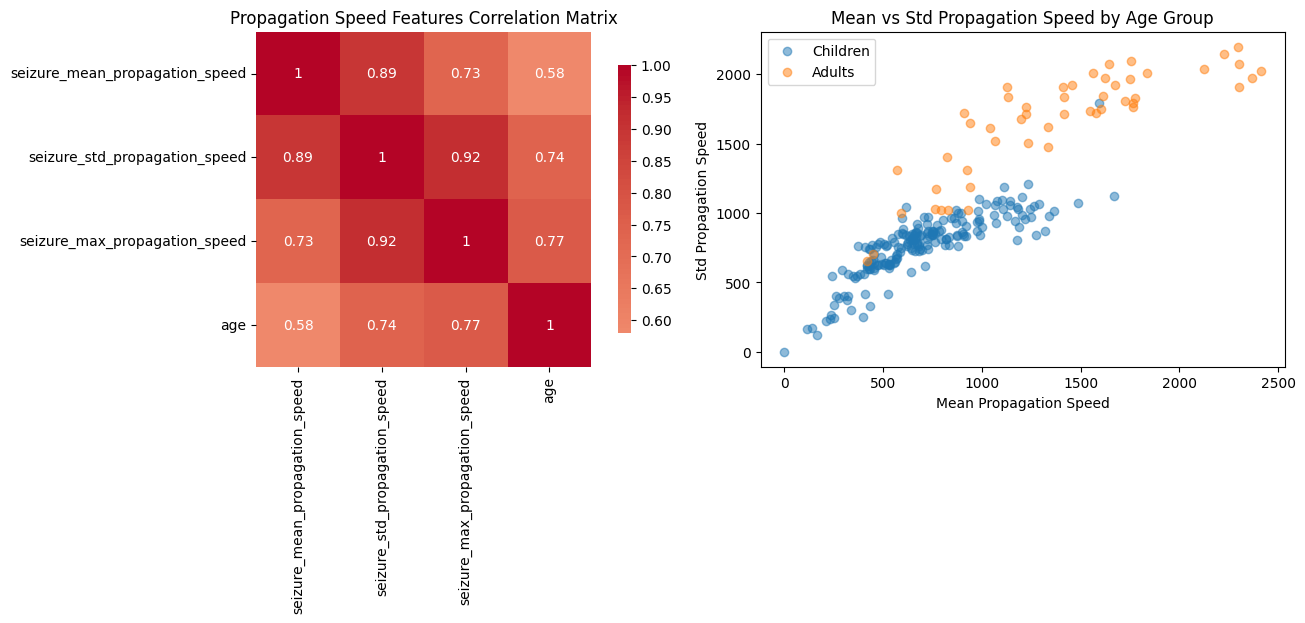


Correlation with Age:
seizure_mean_propagation_speed: 0.5792
seizure_std_propagation_speed: 0.7406
seizure_max_propagation_speed: 0.7677


In [20]:
analyze_propagation_speed_correlations(processed_df, age_threshold=22)